<a href="https://colab.research.google.com/github/seeedata/SK-AI-Data-Academy/blob/main/SK%20hynix%20DRAM%20%EB%82%B4%EB%B6%80%20%ED%9A%8C%EB%A1%9C%EC%9D%98%20%ED%8C%8C%ED%98%95%20%EC%98%88%EC%B8%A1/%5B%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B84%5D%20Transformer%20%EA%B8%B0%EB%B0%98%20%EB%AA%A8%EB%8D%B8%EC%9D%84%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%ED%8C%8C%ED%98%95%20%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [프로젝트4] Transformer 기반 모델을 활용한 파형 예측하기


---


## 프로젝트 목표
---
- Transformer 기반 딥러닝 모델에 적용할 수 있도록 데이터셋을 구성해봅니다.
- pytorch를 활용하여 Transformer 모델을 훈련하고 테스트해봅니다.

## 프로젝트 목차
---

1. **데이터 읽기:** 전압 데이터를 불러오고 numpy array 형태로 변환

2. **데이터 전처리:** 불러온 데이터를 Transformer 모델에 적용할 수 있도록 전처리

3. **머신러닝 모델 수행:** Transformer 모델을 사용하여 학습 수행, 평가 및 예측 수행


## 프로젝트 개요
---

이번 장에서는 최신 AI 기법인 Transformer 딥러닝 모델을 사용해보겠습니다.

Transformer 모델은 RNN 기반 딥러닝 모델과 마찬가지로 시계열 데이터를 입력 받습니다.

따라서, RNN에서와 같은 방법으로 데이터 전처리를 할 수 있습니다.

데이터 전처리 이후에는 pytoch 라이브러리를 활용하여 Transformer 모델을 학습하고 예측 및 평가해보겠습니다.


## 1. 데이터 읽기
---
프로젝트 1에서와 같이 데이터를 불러오고 정제한 후 전처리합니다.


In [ ]:
import pandas as pd

# 데이터 불러오기
df_train = pd.read_csv('./dataset/SKHY_train.txt', delimiter=',', header=0)
df_test = pd.read_csv('./dataset/SKHY_test_answer.txt', delimiter=',', header=0)

# 데이터 정제
# 학습용 데이터와 검증용 데이터의 비율을 9:1로 설정합니다.
train_valid_ratio = 0.9
train_len = int(df_train.shape[0] * train_valid_ratio)
valid_len = df_train.shape[0] - train_len
test_len = df_test.shape[0]
train_data = {
    'time': df_train.iloc[:, 0].values[:train_len],
    'X': df_train.iloc[:, 1].values[:train_len],
    'y': df_train.iloc[:, 2:].values[:train_len]
}
valid_data = {
    'time': df_train.iloc[:, 0].values[train_len:],
    'X': df_train.iloc[:, 1].values[train_len:],
    'y': df_train.iloc[:, 2:].values[train_len:]
}
test_data = {
    'time': df_test.iloc[:, 0].values,
    'X': df_test.iloc[:, 1].values,
    'y': df_test.iloc[:, 2:].values
}

# 데이터 정규화
X_mean = train_data['X'].mean()
X_std = train_data['X'].std()

X_train = (train_data['X'] - X_mean) / X_std
X_train = X_train.reshape(-1, 1)
X_valid = (valid_data['X'] - X_mean) / X_std
X_valid = X_valid.reshape(-1, 1)
X_test = (test_data['X'] - X_mean) / X_std
X_test = X_test.reshape(-1, 1)

y_mean = train_data['y'].mean(axis=0)
y_std = train_data['y'].std(axis=0)
y_train = (train_data['y'] - y_mean) / y_std
y_valid = (valid_data['y'] - y_mean) / y_std
y_test = (test_data['y'] - y_mean) / y_std

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_valid shape: {}, y_valid shape: {}'.format(X_valid.shape, y_valid.shape))
print('X_test shape: {}, y_test shape: {}'.format(X_test.shape, y_test.shape))

X_train shape: (407054, 1), y_train shape: (407054, 5)
X_valid shape: (45229, 1), y_valid shape: (45229, 5)
X_test shape: (193836, 1), y_test shape: (193836, 5)


`X_train`과 `y_train`은 학습데이터, `X_valid`와 `y_valid`는 검증데이터, 그리고 `X_test`와 `y_test`는 테스트 데이터입니다.

## 2. 데이터 전처리
---
읽어온 데이터를 Transformer 모델에 적용할 수 있도록 전처리합니다.


### 2.1 라이브러리 불러오기
---

In [ ]:
import numpy as np

### 2.2 시계열 데이터 생성
---
Transformer 기반의 모델에 적용하기 위해 입력 데이터 (`X`)는 <b><i>[#data, #sequence, #dimension]</i></b>의 shape을 가져야 합니다. <b><i>#data</i></b>는 데이터의 개수이고, <b><i>#sequence</i></b>는 window size이며, <b><i>#dimension</i></b>은 입력 데이터의 차원을 의미합니다. 이는 RNN에서의 데이터 전처리 방법과 동일합니다.

In [ ]:
# 읽어온 데이터를 시계열 데이터로 변환해줍니다.
def process_data(X, y, num_sequences, stride = 1, interval = 1):
    X_ = []
    for i in range(0, num_sequences * interval, interval):
        X_.append(X[i:len(X) - num_sequences * interval + 1 + i])
    X_ = np.asarray(X_)[:, ::stride].transpose().reshape(-1, num_sequences, 1)
    return X_, y[num_sequences * interval-1::stride]

읽어온 데이터는 입력 데이터의 shape이 <b><i>[#data, #dimension]</i></b>입니다. 이를 시계열 데이터의 형식으로 바꾸어주는 `process_data` 함수를 정의하였습니다. `num_sequences` 매개변수는 window_size를 의미하고, `stride`는 각 sequence 데이터 사이의 시간 간격을 의미합니다. `interval`은 같은 window를 구성하는 데이터 간의 시간 간격을 의미합니다. 이때, 출력값 `y`가 입력값의 마지막 시점에서의 출력값이 되도록 합니다.

<img src="./images/image1.png" width="80%">

In [ ]:
num_sequences = 150
stride = 1
interval = 3
X_train2, y_train2 = process_data(X_train, y_train, num_sequences, stride, interval)
X_valid2, y_valid2 = process_data(X_valid, y_valid, num_sequences, stride, interval)
X_test2, y_test2 = process_data(X_test, y_test, num_sequences, stride, interval)

Window size (`num_sequences`)는 150, `stride`는 1, `interval`은 3으로 설정하여 시계열 데이터를 생성합니다.

### 2.3 시계열 데이터 shape 확인
---

In [ ]:
print('X_train2 shape: {}, y_train2 shape: {}'.format(X_train2.shape, y_train2.shape))
print('X_valid2 shape: {}, y_valid2 shape: {}'.format(X_valid2.shape, y_valid2.shape))
print('X_test2 shape: {}, y_test2 shape: {}'.format(X_test2.shape, y_test2.shape))

X_train2 shape: (406605, 150, 1), y_train2 shape: (406605, 5)
X_valid2 shape: (44780, 150, 1), y_valid2 shape: (44780, 5)
X_test2 shape: (193387, 150, 1), y_test2 shape: (193387, 5)


## 3. 머신러닝 모델 수행
---
시계열 데이터를 이용하여 Transformer 모델을 학습하고, 예측 및 평가해보겠습니다. pytorch 라이브러리를 활용하여 Positional encoding과 Transformer을 구현해보겠습니다.


### 3.1 라이브러리 불러오기
---


In [ ]:
import numpy as np
import torch

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

numpy와 pytorch를 import 해줍니다. pytorch는 `import torch`를 통해 불러올 수 있습니다. pytorch는 facebook이 개발한 파이썬 오픈소스 머신러닝 라이브러리로, tensorflow와 더불어 가장 많이 사용되는 신경망 라이브러리입니다. 결과 재현이 쉽도록 random seed를 0으로 고정해줍니다.

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('%s 장치가 감지되었습니다.'%device)

cpu 장치가 감지되었습니다.


`torch.cuda.is_avaliable()`은 작업환경에서 GPU를 활용하여 계산이 가능한지 여부를 알려줍니다. CUDA가 있으면 `device = 'cuda'`로, CUDA가 없으면 `device = 'cpu'`로 하여 연산할 장치를 설정해줍니다.

### 3.2 Transformer 모델 정의
---
먼저 Transformer 모델을 정의해보겠습니다.

#### 3.2.1 Positional encoding
먼저, 입력데이터의 순서 정보를 Transformer 모델에 효율적으로 넣어주기 위한 positional encoding을 구현해보겠습니다.

## [TODO] Transformer 모델 정의하기

아래 주석의 가이드에 따라 아래 순서로 구현합니다.
- 입력데이터의 순서 정보를 Transformer 모델에 효율적으로 넣어주기 위한 positional encoding
- Transformer 모델

In [ ]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_dimension = 10, num_sequences = 150):
        super(PositionalEncoding, self).__init__()

        # shape이 [num_sequences, num_dimension] 인 zero tensor을 pe 변수에 저장해줍니다.
        pe = torch.zeros(num_sequences, num_dimension)
        # [[0], [1], [2], ..., [num_sequences - 1]] 의 tensor을 만들어 position 변수에 저장해줍니다.
        # unsqueeze(1): 생성된 1차원 텐서의 두 번째 차원(axis=1)에 새로운 차원을 추가하여 2차원 텐서로 만든다.
        position = torch.arange(0, num_sequences).unsqueeze(1)
        # positional encoding에서 입력의 위치값을 10000^(2i/num_dimension) 으로 나누어주는 부분이 있습니다.
        # div_term 변수에 다음의 tensor
        # [1/10000^(0/num_dimension), 1/10000^(2/num_dimension), ..., 1/10000^(num_dimension - 2/num_dimension)]
        # 을 저장해줍니다.
        # 이때, overflow을 방지하기 위해 log 공간에서 연산해줍니다.
        div_term = torch.exp(torch.arange(0, num_dimension, 2) * -(torch.log(torch.Tensor([10000.])) / num_dimension))
        # pe 변수의 짝수 dimension에 position * div_term 에 sine을 씌운 값을 저장합니다.
        pe[:, 0::2] = torch.sin(position * div_term)
        # pe 변수의 홀수 dimension에 position * div_term 에 cosine을 씌운 값을 저장합니다.
        pe[:, 1::2] = torch.cos(position * div_term)
        # self.pe에 pe의 shape을 [1, num_sequences, num_dimension]으로 변경하여 저장해줍니다.
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        # 입력 x에 positional encoding된 위치값을 elementwise-sum 해줍니다.
        x = x + self.pe
        return x

#### 3.2.2 Transformer
다음으로, Transformer 모델을 정의해보겠습니다.

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_sequences, num_heads, num_layers):
        super(Transformer, self).__init__()

        # 입력 데이터를 input_size 차원에서 embedding_size 차원으로 임베딩해줍니다.
        self.embedding = torch.nn.Linear(input_size, embedding_size)

        # 위에서 정의한 PositionalEncoding 객체를 생성합니다.
        self.positional_encoder = PositionalEncoding(
            num_dimension = embedding_size, num_sequences = num_sequences
        )
        # Transformer 모델을 정의합니다. 각각의 매개변수에 대해 아래 documentation을 참고하여 이해해봅니다.
        # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # d_model: 임베딩 차원
        # nhead: Multi-Head Attention에서 헤드의 수. 각 헤드가 독립적으로 어텐션을 수행한 후 결과를 결합
        # num_encoder_layers: 인코더 레이어의 수
        # num_decoder_layers: 디코더 레이어의 수
        # dim_feedforward: Feed Forward 신경망의 은닉층 크기
        # batch_first=True: 입력 데이터는 (batch_size, seq_length, embedding_size)
        self.transformer = torch.nn.Transformer(d_model = embedding_size,
                                                nhead = num_heads,
                                                num_encoder_layers = num_layers,
                                                num_decoder_layers = num_layers,
                                                dim_feedforward = hidden_size,
                                                batch_first = True)
        # 마지막 linear layer을 정의합니다.
        self.fc = torch.nn.Linear(embedding_size, output_size)

    def forward(self, X):
        # 먼저, 입력 X를 embedding_size 차원으로 임베딩해줍니다.
        X = self.embedding(X)
        # 일반적인 seq2seq모델에서 정답 y를 한 time-step씩 shift하여 모델에 target 정보로 넣어주게 됩니다.
        # 그러나 우리의 task 는 many-to-one 이므로, target 정보로 0-vector을 넣어줍니다.
        # X[:, :1, :] >> (batch_size, 1, embedding_size)
        # torch.zeros_like: 입력 텐서와 같은 크기와 타입을 가지는 모든 요소가 0인 텐서를 생성
        tgt_input = torch.zeros_like(X[:, :1, :], dtype = X.dtype).to(X.device)
        # 다음으로, 입력 X를 positional encoding 합니다.
        X = self.positional_encoder(X)
        # transformer 모델에 positional encoding한 X와 tgt_input을 넣어줍니다.
        y = self.transformer(X, tgt_input)
        # 마지막으로 linear layer을 거쳐 출력값을 반환합니다.
        y = self.fc(y[:, -1])
        return y


### 3.3 데이터 로더 생성

모델을 학습할 때 전체 데이터에 대해 한꺼번에 학습계수를 갱신하면 메모리를 과도하게 사용하게 되고 과적합이 발생할 수 있습니다. 따라서 일반적으로 딥러닝 모델을 학습할 때에 데이터를 mini-batch 로 나누어 학습하는 stochastic gradient descent 방법을 활용합니다. 이를 위해 학습 시 데이터를 batch size 만큼 불러온 후 모델에 입력하여 학습하여야 하는데, 이로 인해 코드가 복잡해지고 가독성이 떨어질 수 있습니다.

Pytorch는 데이터를 불러오는 부분에서의 코드를 간결화하기 위해 Dataset과 DataLoader 클래스를 제공합니다. Dataset에서 입력데이터와 출력데이터를 매칭하여 저장하며, DataLoader에서 매 학습 iteration마다 데이터를 batch size만큼 불러올 수 있습니다.

이 부분은 RNN에서와 같습니다.

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y

먼저 Dataset을 상속받는 CustomDataset class를 정의합니다. 생성자에서 입력데이터와 출력데이터를 저장합니다. numpy array 형식인 데이터를 `torch.FloatTensor(...)`를 이용하여 pytorch tensor 형식으로 변환해줍니다. `__len__(...)` 메소드는 전체 데이터의 개수를 반환합니다. `__getitem__(self, index)`는 `index` 번째 데이터를 반환합니다.

In [ ]:
training_set = CustomDataset(X = X_train2, y = y_train2)
validation_set = CustomDataset(X = X_valid2, y = y_valid2)
test_set = CustomDataset(X = X_test2, y = y_test2)

`X`에 입력데이터를, `y`에 출력 데이터를 넣어 Dataset 객체를 생성합니다. 이 때, 입력데이터로 차원수를 늘린 `X_train2`을 넣어줍니다.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

학습 시 데이터를 사용자가 설정한 batch size 만큼만 불러올 수 있도록 하기 위해 pytorch 에서 DataLoader 클래스를 이용할 수 있습니다. 이 때, `shuffle = True`로 설정하여 매 에폭마다 데이터가 잘 섞일 수 있도록 해줍니다.

### 3.4 모델 생성

In [ ]:
input_size = X_train2.shape[-1]
embedding_size = 16
output_size = y_train2.shape[-1]
hidden_size = 32
num_heads = 8
num_layers = 2
model = Transformer(input_size = input_size, embedding_size = embedding_size, hidden_size = hidden_size, output_size = output_size,
                    num_sequences = num_sequences, num_heads = num_heads, num_layers = num_layers)
model = model.to(device)
model.positional_encoder.pe = model.positional_encoder.pe.to(device)

`embedding_size`는 입력데이터를 임베딩할 차원을 의미하고, `hidden_size`는 feedforward 네트워크에서의 hidden dimension입니다. `num_heads` 는 multi-head attention 에서의 head의 개수이고, `num_layers`는 encoder와 decoder의 개수입니다. 각각 `hidden_size = 32`, `num_heads = 8`, `num_layers = 2`로 설정하여 Transformer 모델을 생성합니다. `model.to(device)`를 활용하여 연산 장치를 cpu로 할지 cuda로 할지 지정해줍니다.

### 3.5 모델 학습

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

학습 loss는 mean squared error를 이용하며, optimizer는 Adam optimzier를 이용합니다. 학습률은 0.01로 설정합니다.

In [ ]:
EPOCHS = 10
max_iter = 100

학습 batch size는 128로 설정하고, 총 10 에폭 동안 학습합니다. 각 에폭마다 최대 iteration 수는 100으로 설정합니다.

In [ ]:
history = {
    'training_loss': [],
    'validation_loss': []
}

for epoch in range(EPOCHS):
    print('Epoch %d/%d'%(epoch + 1, EPOCHS))

    # 모델 학습을 위해 gradient를 계산하도록 설정합니다.
    model.train()

    for i, data in enumerate(train_dataloader):
        X_batch, y_batch = data
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        if i >= max_iter:
            history['training_loss'].append(loss.item())
            break

        pred = model(X_batch)
        loss = criterion(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('\r%d/%d loss: %f'%(i+1, min(len(X_train2) // batch_size, max_iter), loss), end = '')

    # 한 에폭 동안 학습한 모델을 검증 데이터를 이용하여 평가해봅니다.
    # 학습을 위한 단계가 아니므로, model.eval()을 통해 gradient를 계산하지 않도록 합니다.
    model.eval()
    validation_loss = []
    for i, data in enumerate(valid_dataloader):
        X_batch, y_batch = data
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        if i >= max_iter:
            break

        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        validation_loss.append(loss.item())
    loss = np.mean(validation_loss)
    print(' - val loss: %f'%loss)
    history['validation_loss'].append(loss.item())


Epoch 1/10
100/100 loss: 0.018398 - val loss: 0.021630
Epoch 2/10
100/100 loss: 0.009436 - val loss: 0.006682
Epoch 3/10
100/100 loss: 0.006984 - val loss: 0.003760
Epoch 4/10
100/100 loss: 0.004316 - val loss: 0.002294
Epoch 5/10
100/100 loss: 0.003749 - val loss: 0.002135
Epoch 6/10
100/100 loss: 0.005145 - val loss: 0.001540
Epoch 7/10
100/100 loss: 0.002947 - val loss: 0.001847
Epoch 8/10
100/100 loss: 0.002926 - val loss: 0.001416
Epoch 9/10
100/100 loss: 0.002285 - val loss: 0.002611
Epoch 10/10
100/100 loss: 0.002090 - val loss: 0.001095


모델을 학습합니다. 매 에폭이 끝날때마다 검증용 데이터를 이용하여 loss를 확인해봅니다. 또한, 매 에폭마다 학습 로스와 검증 로스를 history 딕셔너리에 추가해줍니다.

### 3.6 학습 중 Loss 변화 그래프로 확인하기

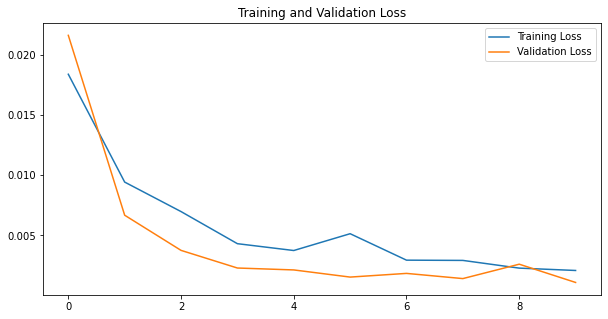

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

train_loss = history['training_loss']
val_loss = history['validation_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3.7 모델 예측

In [ ]:
preds = []
for i, data in enumerate(test_dataloader):
    X_batch, y_batch = data
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    pred = model(X_batch)
    preds.append(pred.detach().to('cpu'))
# 여러 텐서를 하나의 텐서로 결합
pred = torch.cat(preds)

테스트 데이터에 대한 예측 결과를 계산합니다.

### 3.8 모델 성능 평가

In [ ]:
def mse(gt, pred):
    data_len = len(gt)
    return ( (gt - pred) ** 2 ).sum() / data_len

평균 mean squared error을 계산해주는 함수를 정의합니다.

In [ ]:
pred = pred.detach().numpy()
error = mse(pred, y_test2)
print('Transformer 모델의 오차: {}'.format(error))

Transformer 모델의 오차: 0.005374186049969373


`pred`를 `numpy` array로 형변환해주고, MSE를 계산합니다. LSTM 모델의 오차보다 조금 더 높은 오차를 보입니다. Transformer 모델은 일반적으로 sequence가 길고 복잡하며 데이터 수가 매우 많을 때 RNN 모델보다 우수한 경향을 보입니다. 예를 들어 번역 등의 task에서 그렇습니다. 우리 데이터의 경우 이보다는 데이터가 복잡하지 않아 성능이 좋지 않았을 수도 있으며, 또는 hyperparameter 튜닝이 필요해서일 수도 있습니다.

### 3.9 예측결과 시각화

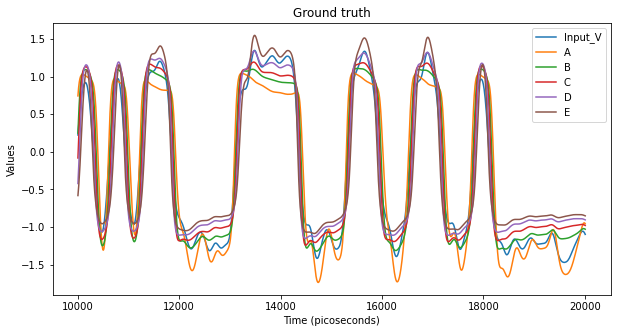

In [ ]:
start_i, end_i = 10000, 20000

fig = plt.figure(figsize = (10,5))
plt.title('Ground truth')
plt.xlabel('Time (picoseconds)')
plt.ylabel('Values')
for i, data in enumerate(np.concatenate([X_test2[:,-1:, 0], y_test2], axis=1).transpose()):
    plt.plot(df_train.iloc[start_i:end_i, 0] * 1e+12, data[start_i:end_i], label = df_train.columns[i+1])
plt.legend(loc = 'upper right')
plt.show()

먼저 정답 데이터를 그래프로 그려봅니다.

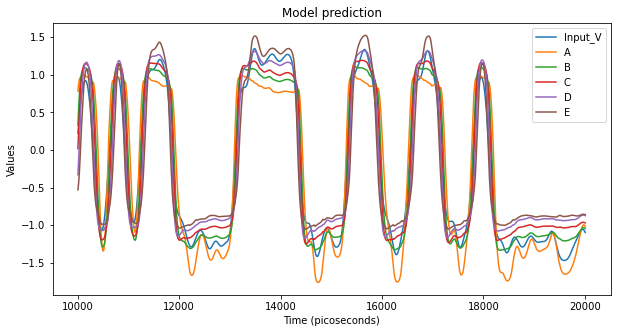

In [ ]:
fig = plt.figure(figsize = (10,5))
plt.title('Model prediction')
plt.xlabel('Time (picoseconds)')
plt.ylabel('Values')
for i, data in enumerate(np.concatenate([X_test2[:,-1:, 0], pred], axis=1).transpose()):
    plt.plot(df_train.iloc[start_i:end_i, 0] * 1e+12, data[start_i:end_i], label = df_train.columns[i+1])
plt.legend(loc = 'upper right')
plt.show()

다음으로 Transformer 모델이 예측한 결과를 그래프로 그려봅니다. 실제 출력전압과 유사하게 예측해내었음을 확인할 수 있습니다.

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>

---